In [3]:
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from pathlib import Path

In [5]:
target_csv_path = Path.cwd() / '..' / 'files' / 'csv' / 'titanic.csv'
titanic = pd.read_csv(target_csv_path)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Plotting

### Histograms

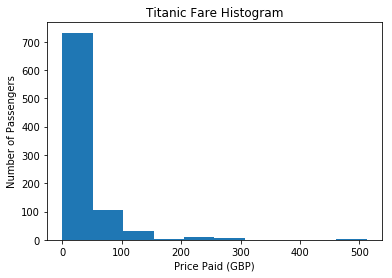

In [ ]:
import matplotlib.pyplot as plt
plt.hist(titanic['Fare'])
plt.title("Titanic Fare Histogram")
plt.xlabel("Price Paid (GBP)")
plt.ylabel("Number of Passengers")
plt.show()

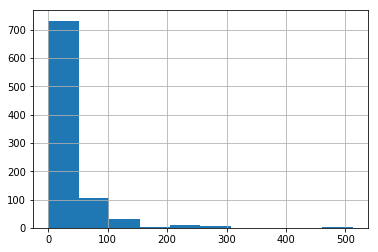

In [ ]:
titanic['Fare'].hist()

### Other Graphs
Pretty much any graph you can imagine is possible with these python based tools. Check out the [matplotlib gallery](http://matplotlib.org/gallery.html) for more.

---
# Simple Modeling
What if we want to use this data to predict who survived?

### Data Cleanup
First we need to take all the variables that would be useful for making predictions. This can involve a little more art than science because in many cases you can create numerical variables out of text variables. For example if we understood the cabin numbering well we could make a variable that indicates which deck they were staying on, or if they were on the port or starboard side, etc.

Here we'll keep it simple and convert the variables 'Sex' and 'Embarked' into numbers.

In [ ]:
titanic.head(3).T

,0,1,2
PassengerId,1,2,3
Survived,0,1,1
Pclass,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina"
Sex,male,female,female
Age,22,38,26
SibSp,1,1,0
Parch,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282
Fare,7.25,71.2833,7.925


In [ ]:
titanic_exploded = pd.get_dummies(
    titanic[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
             'Parch', 'Fare', 'Embarked']])
titanic_exploded.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


As you can see the `get_dummies` command expanded the categorical variables into 1/0 flags where 1 means true and 0 means false. There are two extra categories though. If we know whether or not somebody is female, knowing whether or not they are male is redundant. Similarly we don't need a flag for each of the three ports somebody could have embarked from. If they didn't leave from Cherbourg or Queenstown then we know they must have boarded in Southhampton. So we'll remove these redundant variables.

In [ ]:
titanic_exploded.drop(['Sex_male', 'Embarked_S'], axis=1, inplace=True)
titanic_exploded.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
0,0,3,22.0,1,0,7.2500,0,0,0
1,1,1,38.0,1,0,71.2833,1,1,0
2,1,3,26.0,0,0,7.9250,1,0,0
3,1,1,35.0,1,0,53.1000,1,0,0
4,0,3,35.0,0,0,8.0500,0,0,0


### Null Values
The next thing we need to do before making a predictive model is check for null values. Luckily pandas includes the isnull() function to easily flag the nulls. We can use this to visualize some examples.

In [ ]:
titanic_exploded[titanic_exploded.isnull().any(axis=1)].head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
5,0,3,NaN,0,0,8.4583,0,0,1
17,1,2,NaN,0,0,13.0000,0,0,0
19,1,3,NaN,0,0,7.2250,1,1,0
26,0,3,NaN,0,0,7.2250,0,1,0
28,1,3,NaN,0,0,7.8792,1,0,1


We can use `isnull()` and sum to see how many nulls there are for each variable in our dataset.

In [ ]:
titanic_exploded.isnull().sum()

Survived        0
Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_female      0
Embarked_C      0
Embarked_Q      0
dtype: int64

We now know age is null is about 20% of our data and it's the only piece of our numerical data that's ever null. Age seems like an important variable for our model, so we're going to simply drop the null records. This is often a point of debate though and often nulls are filled in with the mean or median value of that variable, or even will be predicted by another model.

In [ ]:
titanic_non_null = titanic_exploded[titanic_exploded['Age'].notnull()]

### Building the Model
Next we try to build a statistical model. There are tons of different models we could choose here. If you're interested in learning more about difference statistical techniques I highly recommend reading [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/). Most of the code samples are in R, but the book covers the techniques so well and concisely that it's by far the best introductory book on the subject. Also the author makes it free to download in pdf form at the link.

For our example we're going to build a classification tree.

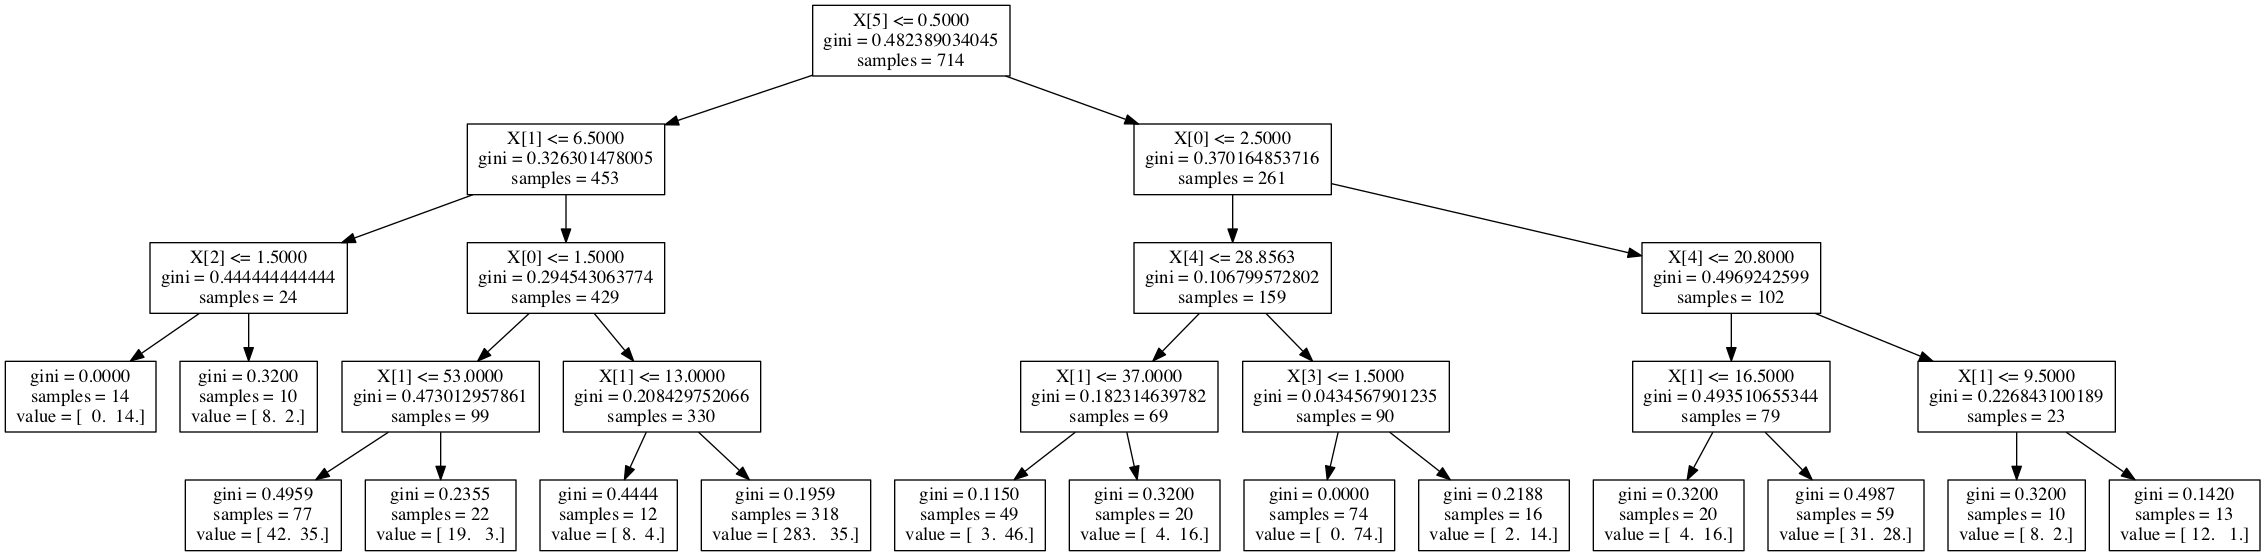

In [ ]:
# pip install scikit-learn
from sklearn import tree
from StringIO import StringIO
from IPython.display import Image #needed to render in notebook
import pydot

c_tree = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)
c_tree = c_tree.fit(titanic_non_null.ix[:,'Pclass':], titanic_non_null['Survived'])

dot_data = StringIO()
tree.export_graphviz(c_tree, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# graph.write_pdf("iris.pdf") # could save as a pdf too

Unfortunately instead of using labels, this nice visualization package shows the variable as X[index] instead of using the variable name. So we'll list the column names below for reference.

*For full disclosure, creating this tree visualization requires installing [graphviz](http://www.graphviz.org/Download..php). On a mac it's easiest to install using macports, on Linux it's easy to install (as always!) using apt-get, and I have no idea about Windows.*

In [ ]:
list(titanic_non_null.ix[:,'Pclass':].columns.values)

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_female',
 'Embarked_C',
 'Embarked_Q']

An easy way to visualize how well the model is working is to look at a confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

# first we use the model to make predictions
predictions = c_tree.predict(titanic_non_null.ix[:,'Pclass':])

conf_mat = confusion_matrix(titanic_non_null['Survived'], predictions)
print(conf_mat)

[[411  13]
 [110 180]]


Or show a fancy graphic

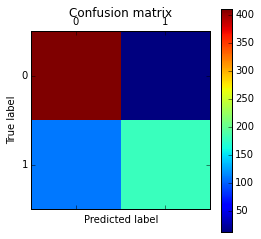

In [ ]:
plt.matshow(conf_mat)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

---
# Wrap Up
This case study was just a short example of what you can do with these techniques. Machine learning and statistics are powerful tools that are being applied to almost all industries and problems today.

For more cool statistics examples check out the [yhat blog](http://blog.yhathq.com/) or you can try your hand at a [kaggle competition](http://www.kaggle.com/competitions).